<picture>
  <source media="(prefers-color-scheme: dark)" srcset="https://vespa.ai/assets/vespa-ai-logo-heather.svg">
  <source media="(prefers-color-scheme: light)" srcset="https://vespa.ai/assets/vespa-ai-logo-rock.svg">
  <img alt="#Vespa" width="200" src="https://vespa.ai/assets/vespa-ai-logo-rock.svg" style="margin-bottom: 25px;">
</picture>

# Feeding performance

This explorative notebook intends to shine some light on the different modes of feeding documents to Vespa.
We will look at these 4 different methods:

1. Using `VespaSync`.
2. Using `VespaAsync`.
3. Using `feed_iterable()`
4. Using [Vespa CLI](https://docs.vespa.ai/en/vespa-cli)


<div class="alert alert-info">
    Refer to <a href="https://pyvespa.readthedocs.io/en/latest/troubleshooting.html">troubleshooting</a>
    for any problem when running this guide.
</div>


Install [Vespa CLI](https://docs.vespa.ai/en/vespa-cli.html).
The `vespacli` python package is just a thin wrapper, allowing for installation through pypi.
> Do NOT install if you already have the Vespa CLI installed.


In [ ]:
#!pip3 install vespacli

[Install pyvespa](https://pyvespa.readthedocs.io/), other dependencies, and start the Docker Daemon.

In [ ]:
#!pip3 install pyvespa datasets plotly>=5.20
#!docker info

## Create an application package

The [application package](https://pyvespa.readthedocs.io/en/latest/reference-api.html#vespa.package.ApplicationPackage)
has all the Vespa configuration files.

For this demo, we will just use a dummy application package without any indexing, just to ease the load for the server, as it is the clients we want to compare in this experiment.


In [1]:
from vespa.package import (
    ApplicationPackage,
    Field,
    Schema,
    Document,
    FieldSet,
)

package = ApplicationPackage(
    name="pyvespafeed",
    schema=[
        Schema(
            name="doc",
            document=Document(
                fields=[
                    Field(name="id", type="string", indexing=["summary"]),
                    Field(name="text", type="string", indexing=["summary"]),
                ]
            ),
            fieldsets=[FieldSet(name="default", fields=["text"])],
        )
    ],
)

Note that the `ApplicationPackage` name cannot have `-` or `_`.


## Deploy the Vespa application

Deploy `package` on the local machine using Docker,
without leaving the notebook, by creating an instance of
[VespaDocker](https://pyvespa.readthedocs.io/en/latest/reference-api.html#vespa.deployment.VespaDocker). `VespaDocker` connects
to the local Docker daemon socket and starts the [Vespa docker image](https://hub.docker.com/r/vespaengine/vespa/).

If this step fails, please check
that the Docker daemon is running, and that the Docker daemon socket can be used by clients (Configurable under advanced settings in Docker Desktop).


In [2]:
from vespa.deployment import VespaDocker

vespa_docker = VespaDocker()
app = vespa_docker.deploy(application_package=package)

Waiting for configuration server, 0/300 seconds...
Waiting for configuration server, 5/300 seconds...
Using plain http against endpoint http://localhost:8080/ApplicationStatus
Waiting for application status, 0/300 seconds...
Using plain http against endpoint http://localhost:8080/ApplicationStatus
Waiting for application status, 5/300 seconds...
Using plain http against endpoint http://localhost:8080/ApplicationStatus
Waiting for application status, 10/300 seconds...
Using plain http against endpoint http://localhost:8080/ApplicationStatus
Waiting for application status, 15/300 seconds...
Using plain http against endpoint http://localhost:8080/ApplicationStatus
Waiting for application status, 20/300 seconds...
Using plain http against endpoint http://localhost:8080/ApplicationStatus
Waiting for application status, 25/300 seconds...
Using plain http against endpoint http://localhost:8080/ApplicationStatus
Application is up!
Finished deployment.


`app` now holds a reference to a [Vespa](https://pyvespa.readthedocs.io/en/latest/reference-api.html#vespa.application.Vespa) instance.


## Preparing the data

In this example we use [HF Datasets](https://huggingface.co/docs/datasets/index) library to stream the
["Cohere/wikipedia-2023-11-embed-multilingual-v3"](https://huggingface.co/datasets/Cohere/wikipedia-2023-11-embed-multilingual-v3) dataset and index in our newly deployed Vespa instance.

The dataset contains wikipedia-pages, and their corresponding embeddings.

> For this exploration we will just use the `id` and `text`-fields

The following uses the [stream](https://huggingface.co/docs/datasets/stream) option of datasets to stream the data without
downloading all the contents locally.

The `map` functionality allows us to convert the
dataset fields into the expected feed format for `pyvespa` which expects a dict with the keys `id` and `fields`:

`{ "id": "vespa-document-id", "fields": {"vespa_field": "vespa-field-value"}}`


In [3]:
from datasets import load_dataset

dataset = load_dataset(
    "Cohere/wikipedia-2023-11-embed-multilingual-v3",
    "simple",
    split="train",
    streaming=True,
)

## Utility function to stream different number of documents


In [4]:
def get_dataset(n_docs: int = 1000):
    return (
        dataset.map(lambda x: {"id": x["_id"] + "-iter", "fields": {"text": x["text"]}})
        .select_columns(["id", "fields"])
        .take(n_docs)
    )

### A dataclass to store the parameters and results of the different feeding methods


In [5]:
from dataclasses import dataclass
from typing import Callable, Optional, Iterable, Dict


@dataclass
class FeedParams:
    name: str
    num_docs: int
    max_connections: int
    function_name: str
    max_workers: Optional[int] = None
    max_queue_size: Optional[int] = None
    num_concurrent_requests: Optional[int] = None


@dataclass
class FeedResult(FeedParams):
    feed_time: Optional[float] = None

### A common callback function to notify if something goes wrong


In [6]:
from vespa.io import VespaResponse


def callback(response: VespaResponse, id: str):
    if not response.is_successful():
        print(
            f"Failed to feed document {id} with status code {response.status_code}: Reason {response.get_json()}"
        )

### Defining our feeding functions


In [7]:
import time
import asyncio


def feed_sync(params: FeedParams, data: Iterable[Dict]) -> FeedResult:
    start_time = time.time()
    with app.syncio(connections=params.max_connections):
        for doc in data:
            app.feed_data_point(
                data_id=doc["id"],
                fields=doc["fields"],
                schema="doc",
                namespace="pyvespa-feed",
                callback=callback,
            )
    end_time = time.time()
    return FeedResult(
        **params.__dict__,
        feed_time=end_time - start_time,
    )


async def feed_async(params: FeedParams, data: Iterable[Dict]) -> FeedResult:
    start_time = time.time()
    tasks = []
    # We use a semaphore to limit the number of concurrent requests, this is useful to avoid
    # running into memory issues when feeding a large number of documents
    semaphore = asyncio.Semaphore(params.num_concurrent_requests)

    async with app.asyncio(
        connections=params.max_connections, total_timeout=params.num_docs // 10
    ) as async_app:
        for doc in data:
            async with semaphore:
                task = asyncio.create_task(
                    async_app.feed_data_point(
                        data_id=doc["id"],
                        fields=doc["fields"],
                        schema="doc",
                        namespace="pyvespa-feed",
                        timeout=10,
                    )
                )
                tasks.append(task)

        await asyncio.wait(tasks, return_when=asyncio.ALL_COMPLETED)

    end_time = time.time()
    return FeedResult(
        **params.__dict__,
        feed_time=end_time - start_time,
    )


def feed_iterable(params: FeedParams, data: Iterable[Dict]) -> FeedResult:
    start = time.time()
    app.feed_iterable(
        data,
        schema="doc",
        namespace="pyvespa-feed",
        operation_type="feed",
        max_queue_size=params.max_queue_size,
        max_workers=params.max_workers,
        max_connections=params.max_connections,
        callback=callback,
    )
    end = time.time()
    sync_feed_time = end - start
    return FeedResult(
        **params.__dict__,
        feed_time=sync_feed_time,
    )

## Defining our hyperparameters


In [8]:
from itertools import product

# We will only run for 1000 documents here as notebook is run as part of CI.
# But you will see some plots when run with 100k documents as well.

num_docs = [1000]

params_by_function = {
    "feed_sync": {
        "num_docs": num_docs,
        "max_connections": [16, 64],
    },
    "feed_async": {
        "num_docs": num_docs,
        "max_connections": [16, 64],
        "num_concurrent_requests": [1000, 10_000],
    },
    "feed_iterable": {
        "num_docs": num_docs,
        "max_connections": [64, 128],
        "max_workers": [16, 64],
        "max_queue_size": [1000, 10000],
    },
}

feed_params = []
# Create one FeedParams instance of each permutation
for func, parameters in params_by_function.items():
    print(f"Function: {func}")
    keys, values = zip(*parameters.items())
    for combination in product(*values):
        settings = dict(zip(keys, combination))
        print(settings)
        feed_params.append(
            FeedParams(
                name=f"{settings['num_docs']}_{settings['max_connections']}_{settings.get('max_workers', 0)}_{func}",
                function_name=func,
                **settings,
            )
        )
    print("\n")  # Just to add space between different functions

Function: feed_sync
{'num_docs': 1000, 'max_connections': 16}
{'num_docs': 1000, 'max_connections': 64}


Function: feed_async
{'num_docs': 1000, 'max_connections': 16, 'num_concurrent_requests': 1000}
{'num_docs': 1000, 'max_connections': 16, 'num_concurrent_requests': 10000}
{'num_docs': 1000, 'max_connections': 64, 'num_concurrent_requests': 1000}
{'num_docs': 1000, 'max_connections': 64, 'num_concurrent_requests': 10000}


Function: feed_iterable
{'num_docs': 1000, 'max_connections': 64, 'max_workers': 16, 'max_queue_size': 1000}
{'num_docs': 1000, 'max_connections': 64, 'max_workers': 16, 'max_queue_size': 10000}
{'num_docs': 1000, 'max_connections': 64, 'max_workers': 64, 'max_queue_size': 1000}
{'num_docs': 1000, 'max_connections': 64, 'max_workers': 64, 'max_queue_size': 10000}
{'num_docs': 1000, 'max_connections': 128, 'max_workers': 16, 'max_queue_size': 1000}
{'num_docs': 1000, 'max_connections': 128, 'max_workers': 16, 'max_queue_size': 10000}
{'num_docs': 1000, 'max_connec

In [9]:
print(f"Total number of feed_params: {len(feed_params)}")

Total number of feed_params: 14


Now, we will need a way to retrieve the callable function from the function name.


In [10]:
# Get reference to function from string name
def get_func_from_str(func_name: str) -> Callable:
    return globals()[func_name]

### Function to clean up after each feed

For a fair comparison, we will delete the data before feeding it again.


In [11]:
from typing import Iterable, Dict

def delete_data(data: Iterable[Dict]):
    app.feed_iterable(
        iter=data,
        schema="doc",
        namespace="pyvespa-feed",
        operation_type="delete",
        callback=callback,
    )

## Main experiment loop


The line below is used to make the code run in Jupyter, as it is already running an event loop


In [12]:
import nest_asyncio

nest_asyncio.apply()

In [13]:
results = []
for params in feed_params:
    print("-" * 50)
    print("Starting feed with params:")
    print(params)
    data = get_dataset(params.num_docs)
    if "async" not in params.function_name:
        feed_result = get_func_from_str(params.function_name)(params=params, data=data)
    else:
        feed_result = asyncio.run(
            get_func_from_str(params.function_name)(params=params, data=data)
        )
    print(feed_result.feed_time)
    results.append(feed_result)
    print("Deleting data")
    delete_data(data)

--------------------------------------------------
Starting feed with params:
FeedParams(name='1000_16_0_feed_sync', num_docs=1000, max_connections=16, function_name='feed_sync', max_workers=None, max_queue_size=None, num_concurrent_requests=None)
15.375110149383545
Deleting data
--------------------------------------------------
Starting feed with params:
FeedParams(name='1000_64_0_feed_sync', num_docs=1000, max_connections=64, function_name='feed_sync', max_workers=None, max_queue_size=None, num_concurrent_requests=None)
11.54607605934143
Deleting data
--------------------------------------------------
Starting feed with params:
FeedParams(name='1000_16_0_feed_async', num_docs=1000, max_connections=16, function_name='feed_async', max_workers=None, max_queue_size=None, num_concurrent_requests=1000)
5.396870136260986
Deleting data
--------------------------------------------------
Starting feed with params:
FeedParams(name='1000_16_0_feed_async', num_docs=1000, max_connections=16, func

In [14]:
# Create a pandas DataFrame with the results
import pandas as pd

df = pd.DataFrame([result.__dict__ for result in results])
df["requests_per_second"] = df["num_docs"] / df["feed_time"]
df

,name,num_docs,max_connections,function_name,max_workers,max_queue_size,num_concurrent_requests,feed_time,requests_per_second
0,1000_16_0_feed_sync,1000,16,feed_sync,NaN,NaN,NaN,15.375110,65.040184
1,1000_64_0_feed_sync,1000,64,feed_sync,NaN,NaN,NaN,11.546076,86.609511
2,1000_16_0_feed_async,1000,16,feed_async,NaN,NaN,1000.0,5.396870,185.292582
3,1000_16_0_feed_async,1000,16,feed_async,NaN,NaN,10000.0,4.975434,200.987489
4,1000_64_0_feed_async,1000,64,feed_async,NaN,NaN,1000.0,4.694310,213.023865
5,1000_64_0_feed_async,1000,64,feed_async,NaN,NaN,10000.0,5.050801,197.988387
6,1000_64_16_feed_iterable,1000,64,feed_iterable,16.0,1000.0,NaN,5.766833,173.405401
7,1000_64_16_feed_iterable,1000,64,feed_iterable,16.0,10000.0,NaN,6.063285,164.927102
8,1000_64_64_feed_iterable,1000,64,feed_iterable,64.0,1000.0,NaN,5.488501,182.199100
9,1000_64_64_feed_iterable,1000,64,feed_iterable,64.0,10000.0,NaN,5.565190,179.688390


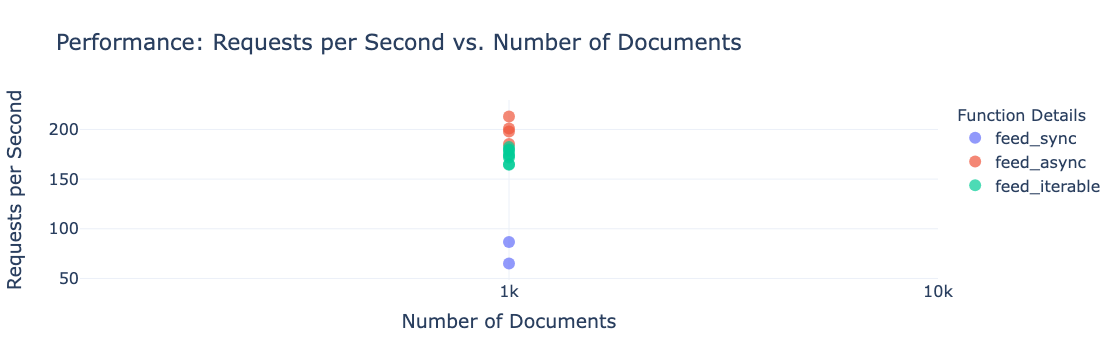

In [17]:
import plotly.express as px


def plot_performance(df: pd.DataFrame):
    # Create a scatter plot with logarithmic scale for both axes using Plotly Express
    fig = px.scatter(
        df,
        x="num_docs",
        y="requests_per_second",
        color="function_name",  # Defines color based on different functions
        log_x=True,  # Set x-axis to logarithmic scale
        log_y=False,  # If you also want the y-axis in logarithmic scale, set this to True
        title="Performance: Requests per Second vs. Number of Documents",
        labels={  # Customizing axis labels
            "num_docs": "Number of Documents",
            "requests_per_second": "Requests per Second",
            "max_workers": "max_workers",
            "max_queue_size": "max_queue_size",
            "max_connections": "max_connections",
            "num_concurrent_requests": "num_concurrent_requests",
        },
        template="plotly_white",  # This sets the style to a white background, adhering to Tufte's minimalist principles
        hover_data=[
            "max_workers",
            "max_queue_size",
            "max_connections",
            "num_concurrent_requests",
        ],  # Additional information to show on hover
    )

    # Update layout for better readability, similar to 'talk' context in Seaborn
    fig.update_layout(
        font=dict(
            size=16,  # Adjusting font size for better visibility, similar to 'talk' context
        ),
        legend_title_text="Function Details",  # Custom legend title
        legend=dict(
            title_font_size=16,
            x=800,  # Adjusting legend position similar to bbox_to_anchor in Matplotlib
            xanchor="auto",
            y=1,
            yanchor="auto",
        ),
        width=800,  # Adjusting width of the plot
    )
    fig.update_xaxes(
        tickvals=[1000, 10000, 100000],  # Set specific tick values
        ticktext=["1k", "10k", "100k"],  # Set corresponding tick labels
    )

    fig.update_traces(
        marker=dict(size=12, opacity=0.7)
    )  # Adjust marker size and opacity
    # Show plot
    fig.show()
    # Save plot as HTML file
    fig.write_html("performance.html")


plot_performance(df)

Here is the corresponding plot when run with 1k, 10k, and 100k documents:


![image](../../_static/feed_performance.png)


Interesting. Let's try to summarize the insights we got from this experiment:

- The `feed_sync` method is the slowest, and does not benefit much from increasing 'max_connections'.
  As there is no concurrency, and each request is blocking, this will be bound by the network latency, which in many cases will be a lot higher than when running against a local VespaDocker instance. For example, if you have 100ms latency against your Vespa instance, you can only feed 10 documents per second using the `VespaSync` method.
- The `feed_async` method is the fastest, and benefits slightly from increasing 'max_connections' regardless of the number of documents. This method is non-blocking, and will likely be even more beneficial when running against a remote Vespa instance, such as [Vespa Cloud](https://cloud.vespa.ai/), when network latency is higher.
- The `feed_iterable` performance is somewhere in between the other two methods, and benefits a lot from increasing `num_workers` when the number of documents increases.

We have not looked at multiprocessing, but there is definitively room to utilize more cores to improve further upon these results.
But there is one alternative that it is interesting to compare against, the Vespa CLI.


## Feeding with Vespa CLI

[Vespa CLI](https://docs.vespa.ai/en/vespa-cli) is a command-line interface for interacting with Vespa.

Among many useful features are a `vespa feed` command that is the recommended way of feeding large datasets into Vespa.
This is optimized for high feeding performance, and it will be interesting to get a feel for how performant feeding to a local Vespa instance is using the CLI.

Note that comparing feeding with the CLI is not entirely fair, as the CLI relies on prepared data files, while the pyvespa methods are streaming the data before feeding it.


## Prepare the data for Vespa CLI

Vespa CLI can feed data from either many .json files or a single .jsonl file with many documents.
The json format needs to be in the following format:

```json
{
  "put": "id:namespace:document-type::document-id",
  "fields": {
    "field1": "value1",
    "field2": "value2"
  }
}
```

Where, `put` is the document operation in this case. Other allowed operations are `get`, `update` and `remove`.

For reference, see https://docs.vespa.ai/en/vespa-cli#cheat-sheet

### Getting the datasets as .jsonl files

Now, let`s save the dataset to 3 different jsonl files of 1k, 10k, and 100k documents.


In [18]:
for n in num_docs:
    print(f"Getting dataset with {n} docs...")
    # First, let's load the dataset in non-streaming mode this time, as we want to save it to a jsonl file
    dataset_cli = load_dataset(
        "Cohere/wikipedia-2023-11-embed-multilingual-v3",
        "simple",
        split=f"train[:{n}]",  # Notice the slicing here, see https://huggingface.co/docs/datasets/loading#slice-splits
        streaming=False,
    )
    # Map to the format expected by the CLI.
    # Note that this differs a little bit from the format expected by the Python API.
    dataset_cli = dataset_cli.map(
        lambda x: {
            "put": f"id:pyvespa-feed:doc::{x['_id']}-json",
            "fields": {"text": x["text"]},
        }
    ).select_columns(["put", "fields"])
    # Save to a jsonl file
    assert len(dataset_cli) == n
    dataset_cli.to_json(f"vespa_feed-{n}.json", orient="records", lines=True)

Getting dataset with 1000 docs...


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Let's look at the first line of one of the saved files to verify the format.


In [19]:
from pprint import pprint
import json

with open("vespa_feed-1000.json", "r") as f:
    sample = f.readline()
    pprint(json.loads(sample))

{'fields': {'text': 'April (Apr.) is the fourth month of the year in the '
                    'Julian and Gregorian calendars, and comes between March '
                    'and May. It is one of the four months to have 30 days.'},
 'put': 'id:pyvespa-feed:doc::20231101.simple_1_0-json'}


Ok, now we are ready to feed the data using Vespa CLI.
We also want to capture the output of feed statistics for each file.


In [20]:
cli_results = {}
for n in num_docs:
    print(f"Feeding {n} docs...")
    output_list = !vespa feed vespa_feed-{n}.json
    results = json.loads("".join(output_list))
    pprint(results)
    cli_results[n] = results

Feeding 1000 docs...
{'feeder.error.count': 0,
 'feeder.inflight.count': 0,
 'feeder.ok.count': 1000,
 'feeder.ok.rate': 1000.0,
 'feeder.operation.count': 1000,
 'feeder.seconds': 0.806,
 'http.exception.count': 0,
 'http.request.MBps': 1.265,
 'http.request.bytes': 1264918,
 'http.request.count': 4277,
 'http.response.MBps': 0.631,
 'http.response.bytes': 630848,
 'http.response.code.counts': {'200': 1000, '429': 3277},
 'http.response.count': 4277,
 'http.response.error.count': 3277,
 'http.response.latency.millis.avg': 131,
 'http.response.latency.millis.max': 401,
 'http.response.latency.millis.min': 1}


In [21]:
cli_results

{1000: {'feeder.operation.count': 1000,
  'feeder.seconds': 0.806,
  'feeder.ok.count': 1000,
  'feeder.ok.rate': 1000.0,
  'feeder.error.count': 0,
  'feeder.inflight.count': 0,
  'http.request.count': 4277,
  'http.request.bytes': 1264918,
  'http.request.MBps': 1.265,
  'http.exception.count': 0,
  'http.response.count': 4277,
  'http.response.bytes': 630848,
  'http.response.MBps': 0.631,
  'http.response.error.count': 3277,
  'http.response.latency.millis.min': 1,
  'http.response.latency.millis.avg': 131,
  'http.response.latency.millis.max': 401,
  'http.response.code.counts': {'200': 1000, '429': 3277}}}

In [22]:
# Let's add the CLI results to the DataFrame
df_cli = pd.DataFrame(
    [
        {
            "name": f"{n}_cli",
            "num_docs": n,
            "max_connections": "unknown",
            "function_name": "cli",
            "max_workers": "unknown",
            "max_queue_size": "n/a",
            "feed_time": result["feeder.seconds"],
        }
        for n, result in cli_results.items()
    ]
)
df_cli["requests_per_second"] = df_cli["num_docs"] / df_cli["feed_time"]
df_cli

,name,num_docs,max_connections,function_name,max_workers,max_queue_size,feed_time,requests_per_second
0,1000_cli,1000,unknown,cli,unknown,n/a,0.806,1240.694789


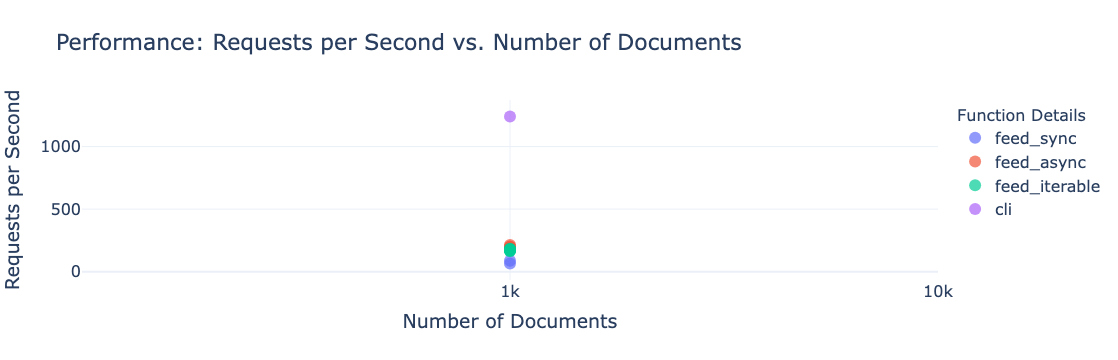

In [23]:
df_total = pd.concat([df, df_cli])

plot_performance(df_total)

And here is the corresponding plot when run with 1k, 10k, and 100k documents:


![image](../../_static/feed_performance-cli.png)


As you can tell, the CLI is orders of magnitude faster.


## Conclusion


- Prefer to use the CLI if you care about performance. 🚀
- If you are using Python, prefer the async method, as it is the fastest way to feed data using `pyvespa`.


## Cleanup


In [24]:
vespa_docker.container.stop()
vespa_docker.container.remove()

## Next steps

Check out some of the other
[examples](https://pyvespa.readthedocs.io/en/latest/examples.html) in the documentation.
